# 1. Function derivatives using MPO-MPS product (25 points)

In [1]:
using ITensors
using Plots
using HDF5

Define function of interest

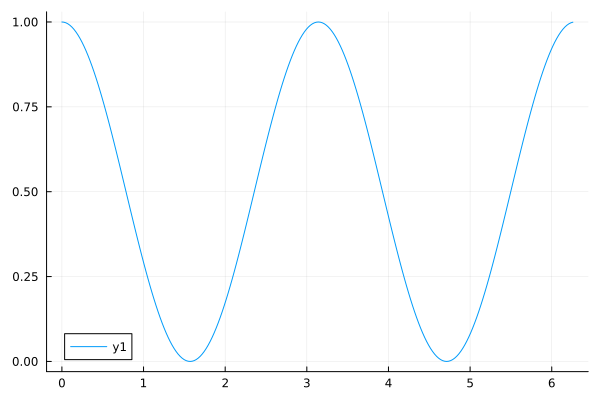

In [2]:
N = 8; # Number of sites
s = siteinds("Qubit", N); # Indices for all sites
xs = range(0, 2pi*(1-(1/2^N)), length=2^N); # Sampling grid points
step_size = 2pi/(2^N);

f(x) = cos(x).^2;
ys = f.(xs);

plot(xs, ys) # Plotting the function

Encode function as MPS

In [3]:
cutoff = 1E-16;
χ = 30;

ψ = MPS(ys, s, cutoff=cutoff, maxdim=χ);

orthogonalize!(ψ,1)

@show linkdims(ψ);

linkdims(ψ) = [2, 3, 3, 3, 3, 2, 1]


Define MPO for first and second derivatives, using central finite difference up to eighth order

In [4]:
# Left shift:

left_ls = zeros(2, 2, 2) 
middle_ls = zeros(2, 2, 2, 2) 
right_ls = zeros(2, 2, 2) 

left_ls[1, 2, 2] = 1
left_ls[2, 1, 1] = 1
middle_ls[1, 1, 1, 1] = 1
middle_ls[1, 2, 2, 1] = 1
middle_ls[2, 2, 1, 1] = 1
middle_ls[2, 1, 2, 2] = 1
right_ls[1, 1, 1] = 1
right_ls[1, 2, 2] = 1
right_ls[2, 1, 2] = 1
right_ls[2, 2, 1] = 1

H_ls = MPO(N);

α = [Index(2) for i in 1:(N-1)]; # bond indices

for i = 1:N
    if i == 1 # first site
        H_ls[i] = ITensor(left_ls, s[i], s[i]', α[i]);
    elseif i == N # last site
        H_ls[i] = ITensor(right_ls, α[i-1], s[i], s[i]');
    else # middle site
        H_ls[i] = ITensor(middle_ls, α[i-1], s[i], s[i]', α[i]);
    end
end

orthogonalize!(H_ls,1);

# Right shift:

left_rs = zeros(2, 2, 2) 
middle_rs = zeros(2, 2, 2, 2) 
right_rs = zeros(2, 2, 2) 

left_rs[1, 2, 1] = 1
left_rs[2, 1, 2] = 1
middle_rs[1, 1, 1, 1] = 1
middle_rs[1, 2, 2, 1] = 1
middle_rs[2, 1, 2, 1] = 1
middle_rs[2, 2, 1, 2] = 1
right_rs[1, 1, 1] = 1
right_rs[1, 2, 2] = 1
right_rs[2, 1, 2] = 1
right_rs[2, 2, 1] = 1

H_rs = MPO(N);

α = [Index(2) for i in 1:(N-1)]; # bond indices

for i = 1:N
    if i == 1 # first site
        H_rs[i] = ITensor(left_rs, s[i], s[i]', α[i]);
    elseif i == N # last site
        H_rs[i] = ITensor(right_rs, α[i-1], s[i], s[i]');
    else # middle site
        H_rs[i] = ITensor(middle_rs, α[i-1], s[i], s[i]', α[i]);
    end
end

orthogonalize!(H_rs,1);

# Identity:

left_id = zeros(2, 2, 1) 
middle_id = zeros(1, 2, 2, 1) 
right_id = zeros(1, 2, 2) 

left_id[1, 1, 1] = 1
left_id[2, 2, 1] = 1
middle_id[1, 1, 1, 1] = 1
middle_id[1, 2, 2, 1] = 1
right_id[1, 1, 1] = 1
right_id[1, 2, 2] = 1

H_id = MPO(N);

α = [Index(1) for i in 1:(N-1)]; # bond indices

for i = 1:N
    if i == 1 # first site
        H_id[i] = ITensor(left_id, s[i], s[i]', α[i]);
    elseif i == N # last site
        H_id[i] = ITensor(right_id, α[i-1], s[i], s[i]');
    else # middle site
        H_id[i] = ITensor(middle_id, α[i-1], s[i], s[i]', α[i]);
    end
end

orthogonalize!(H_id,1);

# Define derivatives
#H_dudx = 0.5*(H_ls - H_rs)/step_size; # First derivative
#H_d2udx2 = (H_rs + H_ls - 2*H_id)/(step_size^2); # Second derivative


MPO
[1] ((dim=2|id=998|"Qubit,Site,n=1"), (dim=2|id=998|"Qubit,Site,n=1")', (dim=1|id=318))
[2] ((dim=2|id=161|"Qubit,Site,n=2"), (dim=2|id=161|"Qubit,Site,n=2")', (dim=1|id=304), (dim=1|id=318))
[3] ((dim=2|id=214|"Qubit,Site,n=3"), (dim=2|id=214|"Qubit,Site,n=3")', (dim=1|id=659), (dim=1|id=304))
[4] ((dim=2|id=528|"Qubit,Site,n=4"), (dim=2|id=528|"Qubit,Site,n=4")', (dim=1|id=958), (dim=1|id=659))
[5] ((dim=2|id=547|"Qubit,Site,n=5"), (dim=2|id=547|"Qubit,Site,n=5")', (dim=1|id=297), (dim=1|id=958))
[6] ((dim=2|id=186|"Qubit,Site,n=6"), (dim=2|id=186|"Qubit,Site,n=6")', (dim=1|id=452), (dim=1|id=297))
[7] ((dim=2|id=120|"Qubit,Site,n=7"), (dim=2|id=120|"Qubit,Site,n=7")', (dim=1|id=560), (dim=1|id=452))
[8] ((dim=2|id=437|"Qubit,Site,n=8"), (dim=2|id=437|"Qubit,Site,n=8")', (dim=1|id=560))


### c) Calculate the first derivative of the function f(x) = cos2(x) in the range 0 ≤ x < 2π, using an eight-order central finite difference (5 points).
###  d) Calculate the second derivative of the function f(x) = cos2(x) in the range 0 ≤ x < 2π, using an eight-order central finite difference (5 points).

In [5]:
#hh=deepcopy(H_rs);
#C=MPO(N);
#C = prime(hh)*H_rs*H_rs*H_rs
H_rs4=apply(H_rs,H_rs,H_rs,H_rs);
H_ls4=apply(H_ls,H_ls,H_ls,H_ls);
H_rs3=apply(H_rs,H_rs,H_rs);
H_ls3=apply(H_ls,H_ls,H_ls);
H_rs2=apply(H_rs,H_rs);
H_ls2=apply(H_ls,H_ls);

H_dudx= (1/280*H_rs4-4/105*H_rs3+1/5*H_rs2-4/5*H_rs+4/5*H_ls-1/5*H_ls2+4/105*H_ls3-1/280*H_ls4)/step_size;
H_d2udx2 = (-1/560*H_rs4+8/315*H_rs3-1/5*H_rs2+8/5*H_rs-205/72*H_id+8/5*H_ls-1/5*H_ls2+8/315*H_ls3-1/560*H_ls4)/(step_size^2);

Analytical formula of derivatives

In [6]:

f(x) = -sin(2*x);
yd = f.(xs);
f(x) = -2 * cos(2x);
ydd = f.(xs);


Apply derivatives to MPS encoding function

In [7]:
Deriv1 = apply(H_dudx,ψ);
Deriv2 = apply(H_d2udx2,ψ);

@show linkdims(Deriv1);
@show linkdims(Deriv2);

linkdims(Deriv1) = [2, 2, 2, 2, 2, 1, 1]
linkdims(Deriv2) = [4, 4, 3, 4, 2, 1, 1]


### e) Calculate the overlap between the normalized MPS results of c) and d), and the normalized analytical results encoded as MPS (5 points).

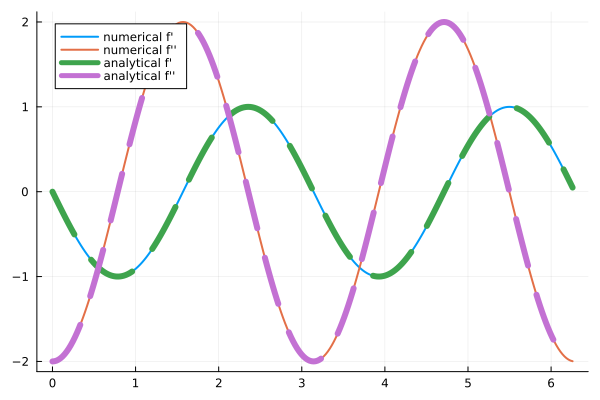

In [8]:
# Recovering the original big tensors
Big_ψ1 = contract(Deriv1); 
Big_ψ2 = contract(Deriv2); 

# Changing the format from ITensor to Julia array for plotting
J_recon1 = Array(Big_ψ1, s) 
J_recon2 = Array(Big_ψ2, s) 

# Reshaping from N-dimentional tensor to regular array
ys_recon1 = reshape(J_recon1,2^N,1) 
ys_recon2 = reshape(J_recon2,2^N,1) 

# Plotting the reconstructed derivatives of the function
plot(xs, ys_recon1,label="numerical f' ",linewidth=2) 
plot!(xs, ys_recon2,label="numerical f'' ",linewidth=2) 
plot!(xs, yd,label="analytical f' ",linewidth=6,linestyle=:dash) 
plot!(xs, ydd,label="analytical f'' ",linewidth=6,linestyle=:dash) 

# Problem2: MPS solution of Burgers’ equation (25 points)

In [9]:
N = 8; # Number of sites
s_x = siteinds("Qubit", N); # Indices for all sites
xb = range(0, (1-(1/2^N)), length=2^N); # Sampling grid points

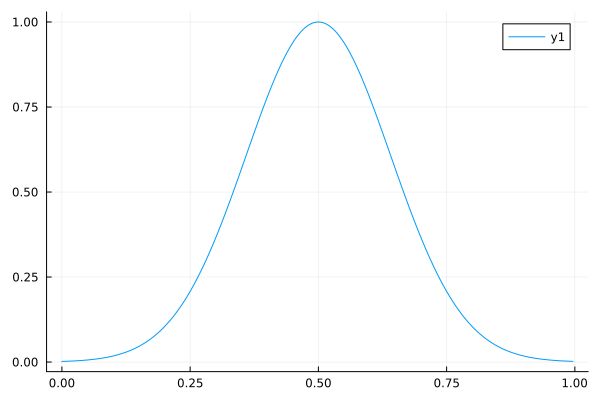

In [10]:

step_size = 1/(2^N);
Re=1000;
dt=0.001;
final_t=0.24;
tb = range(0, final_t, step=dt);
f(x) = exp(-8*pi*(x-0.5).^2);
yb = f.(xb);

plot(xb, yb)

### a) Encode the initial condition as an MPS, and define the derivative operators as MPOs using eight-order central finite difference (2 points).

In [11]:
utoff = 1E-30;
χ = 8;

ϕ = MPS(yb, s_x, cutoff=cutoff, maxdim=χ);

orthogonalize!(ϕ,1)

@show linkdims(ϕ);

linkdims(ϕ) = [2, 4, 5, 6, 8, 4, 2]


In [12]:
# Left shift:

left_ls = zeros(2, 2, 2) 
middle_ls = zeros(2, 2, 2, 2) 
right_ls = zeros(2, 2, 2) 

left_ls[1, 2, 2] = 1
left_ls[2, 1, 1] = 1
middle_ls[1, 1, 1, 1] = 1
middle_ls[1, 2, 2, 1] = 1
middle_ls[2, 2, 1, 1] = 1
middle_ls[2, 1, 2, 2] = 1
right_ls[1, 1, 1] = 1
right_ls[1, 2, 2] = 1
right_ls[2, 1, 2] = 1
right_ls[2, 2, 1] = 1

H_ls = MPO(N);

α = [Index(2) for i in 1:(N-1)]; # bond indices

for i = 1:N
    if i == 1 # first site
        H_ls[i] = ITensor(left_ls, s_x[i], s_x[i]', α[i]);
    elseif i == N # last site
        H_ls[i] = ITensor(right_ls, α[i-1], s_x[i], s_x[i]');
    else # middle site
        H_ls[i] = ITensor(middle_ls, α[i-1], s_x[i], s_x[i]', α[i]);
    end
end

orthogonalize!(H_ls,1);

# Right shift:

left_rs = zeros(2, 2, 2) 
middle_rs = zeros(2, 2, 2, 2) 
right_rs = zeros(2, 2, 2) 

left_rs[1, 2, 1] = 1
left_rs[2, 1, 2] = 1
middle_rs[1, 1, 1, 1] = 1
middle_rs[1, 2, 2, 1] = 1
middle_rs[2, 1, 2, 1] = 1
middle_rs[2, 2, 1, 2] = 1
right_rs[1, 1, 1] = 1
right_rs[1, 2, 2] = 1
right_rs[2, 1, 2] = 1
right_rs[2, 2, 1] = 1

H_rs = MPO(N);

α = [Index(2) for i in 1:(N-1)]; # bond indices

for i = 1:N
    if i == 1 # first site
        H_rs[i] = ITensor(left_rs, s_x[i], s_x[i]', α[i]);
    elseif i == N # last site
        H_rs[i] = ITensor(right_rs, α[i-1], s_x[i], s_x[i]');
    else # middle site
        H_rs[i] = ITensor(middle_rs, α[i-1], s_x[i], s_x[i]', α[i]);
    end
end

orthogonalize!(H_rs,1);

# Identity:

left_id = zeros(2, 2, 1) 
middle_id = zeros(1, 2, 2, 1) 
right_id = zeros(1, 2, 2) 

left_id[1, 1, 1] = 1
left_id[2, 2, 1] = 1
middle_id[1, 1, 1, 1] = 1
middle_id[1, 2, 2, 1] = 1
right_id[1, 1, 1] = 1
right_id[1, 2, 2] = 1

H_id = MPO(N);

α = [Index(1) for i in 1:(N-1)]; # bond indices

for i = 1:N
    if i == 1 # first site
        H_id[i] = ITensor(left_id, s_x[i], s_x[i]', α[i]);
    elseif i == N # last site
        H_id[i] = ITensor(right_id, α[i-1], s_x[i], s_x[i]');
    else # middle site
        H_id[i] = ITensor(middle_id, α[i-1], s_x[i], s_x[i]', α[i]);
    end
end

orthogonalize!(H_id,1);

# Define derivatives
#H_dudx = 0.5*(H_ls - H_rs)/step_size; # First derivative
#H_d2udx2 = (H_rs + H_ls - 2*H_id)/(step_size^2); # Second derivative


MPO
[1] ((dim=2|id=264|"Qubit,Site,n=1"), (dim=2|id=264|"Qubit,Site,n=1")', (dim=1|id=445))
[2] ((dim=2|id=786|"Qubit,Site,n=2"), (dim=2|id=786|"Qubit,Site,n=2")', (dim=1|id=163), (dim=1|id=445))
[3] ((dim=2|id=139|"Qubit,Site,n=3"), (dim=2|id=139|"Qubit,Site,n=3")', (dim=1|id=505), (dim=1|id=163))
[4] ((dim=2|id=871|"Qubit,Site,n=4"), (dim=2|id=871|"Qubit,Site,n=4")', (dim=1|id=972), (dim=1|id=505))
[5] ((dim=2|id=152|"Qubit,Site,n=5"), (dim=2|id=152|"Qubit,Site,n=5")', (dim=1|id=405), (dim=1|id=972))
[6] ((dim=2|id=11|"Qubit,Site,n=6"), (dim=2|id=11|"Qubit,Site,n=6")', (dim=1|id=958), (dim=1|id=405))
[7] ((dim=2|id=184|"Qubit,Site,n=7"), (dim=2|id=184|"Qubit,Site,n=7")', (dim=1|id=262), (dim=1|id=958))
[8] ((dim=2|id=839|"Qubit,Site,n=8"), (dim=2|id=839|"Qubit,Site,n=8")', (dim=1|id=262))


In [13]:
#hh=deepcopy(H_rs);
#C=MPO(N);
#C = prime(hh)*H_rs*H_rs*H_rs
H_rs4=apply(H_rs,H_rs,H_rs,H_rs);
H_ls4=apply(H_ls,H_ls,H_ls,H_ls);
H_rs3=apply(H_rs,H_rs,H_rs);
H_ls3=apply(H_ls,H_ls,H_ls);
H_rs2=apply(H_rs,H_rs);
H_ls2=apply(H_ls,H_ls);

H_dudx= (1/280*H_rs4-4/105*H_rs3+1/5*H_rs2-4/5*H_rs+4/5*H_ls-1/5*H_ls2+4/105*H_ls3-1/280*H_ls4)/step_size;
H_d2udx2 = (-1/560*H_rs4+8/315*H_rs3-1/5*H_rs2+8/5*H_rs-205/72*H_id+8/5*H_ls-1/5*H_ls2+8/315*H_ls3-1/560*H_ls4)/(step_size^2);

In [14]:
f(x) = -8*pi*exp(-2*pi*(1 - 2*x).^2) *(-1 + 2*x)
yd = f.(xb);
f(x) = 16*pi*exp(-2*pi*(1-2*x).^2)*(4*pi*(1-2*x).^2-1);
ydd = f.(xb);

In [15]:
Deriv_x1 = apply(H_dudx,ϕ);
Deriv_x2 = apply(H_d2udx2,ϕ);

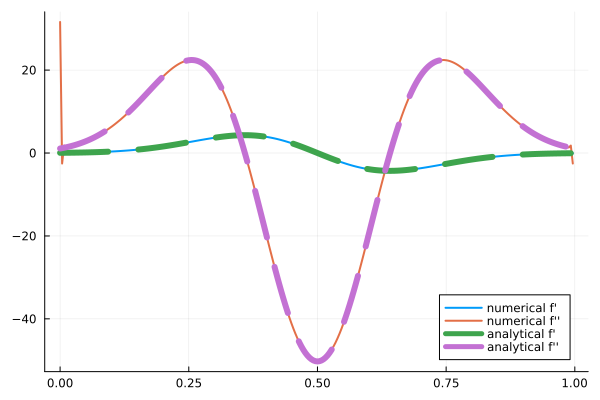

In [16]:

Big_ϕ1 = contract(Deriv_x1); 
Big_ϕ2 = contract(Deriv_x2); 

# Changing the format from ITensor to Julia array for plotting
J_recon1 = Array(Big_ϕ1, s_x) 
J_recon2 = Array(Big_ϕ2, s_x) 

# Reshaping from N-dimentional tensor to regular array
ys_recon1 = reshape(J_recon1,2^N,1) 
ys_recon2 = reshape(J_recon2,2^N,1) 

# Plotting the reconstructed derivatives of the function
plot(xb, ys_recon1,label="numerical f' ",linewidth=2) 
plot!(xb, ys_recon2,label="numerical f'' ",linewidth=2) 
plot!(xb, yd,label="analytical f' ",linewidth=6,linestyle=:dash) 
plot!(xb, ydd,label="analytical f'' ",linewidth=6,linestyle=:dash) 
#plot!(xb, yb)

### b) Implement a time loop for calculating u(x, t + ∆t) from u(x, t), approximating the time derivative as (first order forward finite difference)
### ∂u ≈ u(x,t+∆t)−u(x,t). (3) ∂t ∆t
### Note that the Hadamard product is necessary for the nonlinear term of the equation (15 points).

In [17]:
#create hadamard_product_MPO
had = MPO(N);
had .= convert(MPO, ϕ)
for i = 1:N
    had[i] *= δ(s_x[i], s_x[i]', s_x[i]'')
end

had = replaceprime(had, 2 => 0)

#ψ3_Had = apply(had, Deriv_x1)

#@show linkdims(ψ3_Had);

### c) In a single figure, plot the results of u(x, t) as a function of x for truncation parameter χ = 8 and times t = 0, 0.06, 0.12, 0.18, 0.24 (4 points).

t=0
t=0.060000000000000046
t=0.12000000000000009
t=0.18000000000000013
t=0.24000000000000019


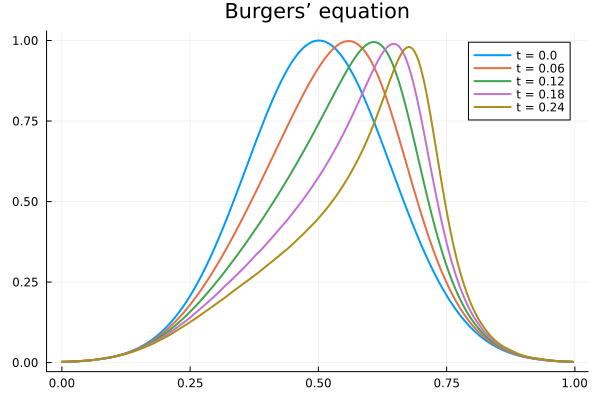

In [18]:
cutoff = 1E-30;
χ =8
Re=1000;
ϕ = MPS(yb, s_x, cutoff=cutoff, maxdim=χ);

orthogonalize!(ϕ,1)
t=0;
runs=0;
    #u_xt = []
saved_times = [0.0, 0.06, 0.12, 0.18, 0.24]
saved_steps = saved_times./dt;

    #P=plot(xb, yb,label= "t=0")
    #println("00")
P=plot()
while t <= final_t+0.01
    Deriv1 = apply(H_dudx,ϕ,maxdim=χ);
    ϕ_Had = apply(had, Deriv1,maxdim=χ);
    Deriv2 = apply(H_d2udx2,ϕ,maxdim=χ);

    ϕ_next = +(ϕ,(dt/Re)*Deriv2,(-dt)*ϕ_Had  ; maxdim=χ);
        
    if runs in saved_steps
        Big_ϕ = contract(ϕ_next); 
        J_recon = Array(Big_ϕ, s_x) 
        y_recon = reshape(J_recon,2^N,1) 
        plot!(xb, y_recon, label="t = $(round(t, digits=2))", lw=2)
        title!("Burgers’ equation")
        println("t=$t")
    end
    runs+=1;
    ϕ = ϕ_next;
    t=t+dt;
end   
display(P)

[ Info: Saved animation to /Users/user/Desktop/codes/labcodes/Tensor_network/HW/hw2/burger_equation.gif


Plots.AnimatedGif("/Users/user/Desktop/codes/labcodes/Tensor_network/HW/hw2/burger_equation.gif")
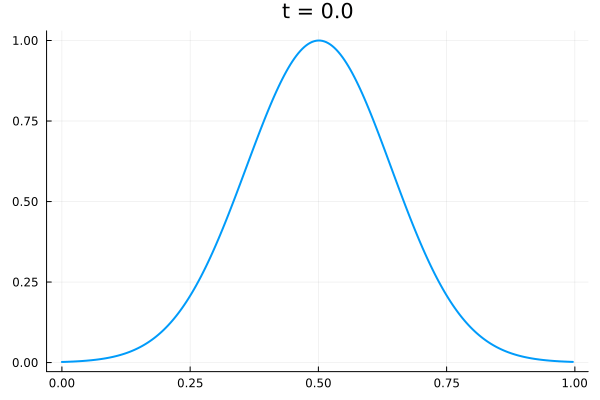

In [19]:
using Plots
χ =8
ϕ = MPS(yb, s_x, cutoff=cutoff, maxdim=χ);

orthogonalize!(ϕ,1)
t=0
#dt =1e-4;
tmax=0.5;
nmax=round(tmax/dt);
anim = Animation()
for n=1:nmax
    Deriv1 = apply(H_dudx,ϕ);
    ϕ_Had = apply(had, Deriv1);
    Deriv2 = apply(H_d2udx2,ϕ);

    ϕ_next = +(ϕ,(dt/Re)*Deriv2,(-dt)*ϕ_Had  ; maxdim=χ);
    
    
    Big_ϕ = contract(ϕ_next); 
    J_recon = Array(Big_ϕ, s_x) 
    y_recon = reshape(J_recon,2^N,1) 
    p=plot(xb, y_recon, legend= false ,title="t = $(round(t, digits=2))", lw=2)
    #println("t=$t")
    frame(anim,p)
    ϕ = ϕ_next;
    t=t+dt;
end
gif(anim, "burger_equation.gif", fps=100)

In [20]:
mp4(anim, "burger_equation.mp4", fps=100)


[ Info: Saved animation to /Users/user/Desktop/codes/labcodes/Tensor_network/HW/hw2/burger_equation.mp4


Plots.AnimatedGif("/Users/user/Desktop/codes/labcodes/Tensor_network/HW/hw2/burger_equation.mp4")

### d) Which is the minimal truncation parameter χ for obtaining good results? (4 points).

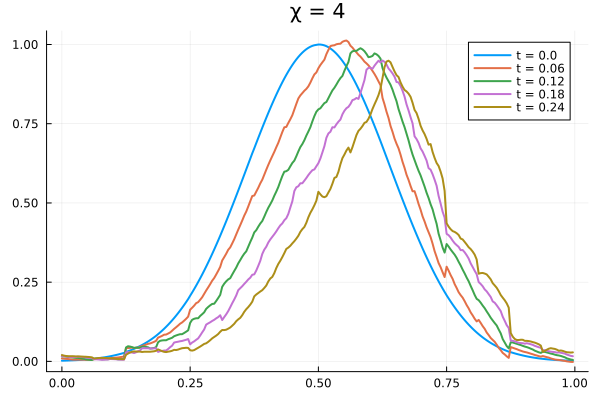

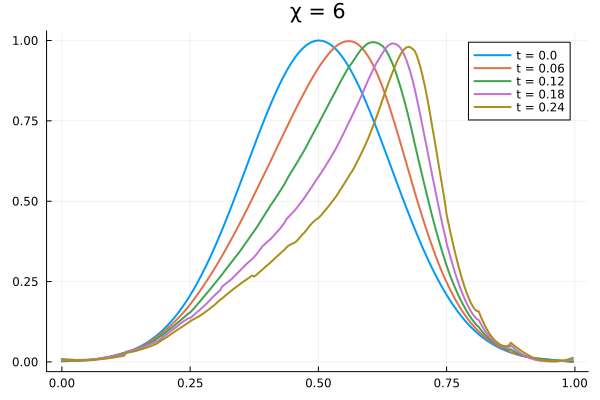

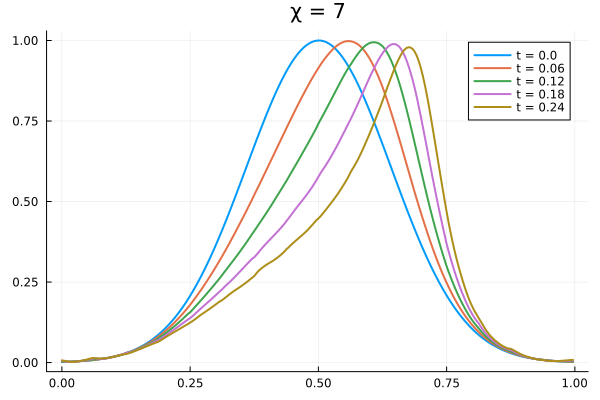

In [21]:
for χ = [4,6,7];
    cutoff = 1E-30;

    Re=1000;
    ϕ = MPS(yb, s_x, cutoff=cutoff, maxdim=χ);

    orthogonalize!(ϕ,1)
    t=0;
    runs=0;
    #u_xt = []
    saved_times = [0.0, 0.06, 0.12, 0.18, 0.24]
    saved_steps = saved_times./dt;

    #P=plot(xb, yb,label= "t=0")
    #println("00")
    P=plot()
    while t <= final_t+0.01
        Deriv1 = apply(H_dudx,ϕ,maxdim=χ);
        ϕ_Had = apply(had, Deriv1,maxdim=χ);
        Deriv2 = apply(H_d2udx2,ϕ,maxdim=χ);

        ϕ_next = +(ϕ,(dt/Re)*Deriv2,(-dt)*ϕ_Had  ; maxdim=χ);
        
        if runs in saved_steps
            Big_ϕ = contract(ϕ_next); 
            J_recon = Array(Big_ϕ, s_x) 
            y_recon = reshape(J_recon,2^N,1) 
            plot!(xb, y_recon, label="t = $(round(t, digits=2))", lw=2)
            title!("χ = $χ")
            #println("t=$t")
            #plot!(P,pl)
        end
        runs+=1;
        ϕ = ϕ_next;
        t=t+dt;
    end
    display(P)
    
end


# problem4: DMRG of spin-1/2 Hamiltonian (35 points)

In [22]:
N = 30 # System size
J1 = 1; # Hopping parameters
J2 = 0.5;
h=2;
#PBC = 0; # Periodic boundary conditions

# Define N S=1/2 spin indices
sites = siteinds("S=1/2",N);

### a) Implement the MPO using the OpSum function of ITensor. Note that the required spin operators Sα (α = x, z) can be found in S = 1/2 and Qubit SiteTypes (3 points).


In [23]:
function Hamiltonian(N,sites,J1,J2,h)

    # Initiate construction
    ops = OpSum()

    # Hopping terms
    for j=1:N-1
        ops += J1,"Sz",j,"Sz",j+1
        ops += J1,"Sz",j,"Sz",j+1    
    end
    for j=1:N-2
        ops += J2,"Sz",j,"Sz",j+2
        ops += J2,"Sz",j,"Sz",j+2    
    end
    for j=1:N
        ops += -h,"Sx",j
    end

    # PBC if required
   

    H = MPO(ops,sites);
    
    return H;
    
end;

### b) Define an initial MPS which encodes the antiferromagnetic state | ↑↓↑↓ · · · ↑↓⟩ (3 points).


In [24]:
function InitialState(sites,N)
    
    state = [isodd(n) ? "Up" : "Dn" for n=1:N];
    ψi = MPS(sites,state);
    
    return ψi;
end

InitialState (generic function with 1 method)

### c) Calculate the ground state |ψ0⟩ and ground state energy E0 of the Hamiltonian, using DMRG and the antiferromagetic state as starting point. You are free to decide on the following parameters: number of sweeps, values of bond dimension χ, values of cutoff error, and tolerance of convergence of energy (15 points). ##

In [25]:
function GroundState(H,ψi)

    # Do many sweeps of DMRG, gradually increasing the maximum MPS bond dimension
    nsweeps = 100;
    maxdim = 100;
    cutoff = 1E-12;

    # Run the DMRG algorithm for ground state   
    energy0,ψ0 = dmrg(H,ψi; nsweeps, maxdim, cutoff, outputlevel=1);

    @show energy0

    # Orthonormalize state. Leave site 1 as orthogonalization center
    orthogonalize!(ψ0,1)

    return energy0, ψ0;
    
end

GroundState (generic function with 1 method)

In [26]:
# Define spin Hamiltonian
H = Hamiltonian(N,sites,J1,J2,h);
ψi = InitialState(sites,N);
# Calculate ground state
E0,ψ0 = GroundState(H,ψi);

After sweep 1 energy=-31.749485125579724  maxlinkdim=4 maxerr=0.00E+00 time=6.429
After sweep 2 energy=-31.75134883424907  maxlinkdim=12 maxerr=9.45E-13 time=0.043
After sweep 3 energy=-31.75134883509473  maxlinkdim=12 maxerr=6.39E-13 time=0.041
After sweep 4 energy=-31.75134883509473  maxlinkdim=12 maxerr=6.37E-13 time=0.041
After sweep 5 energy=-31.751348835094674  maxlinkdim=12 maxerr=6.37E-13 time=0.033
After sweep 6 energy=-31.75134883509467  maxlinkdim=12 maxerr=6.37E-13 time=0.032
After sweep 7 energy=-31.75134883509474  maxlinkdim=12 maxerr=6.37E-13 time=0.037
After sweep 8 energy=-31.75134883509473  maxlinkdim=12 maxerr=6.37E-13 time=0.033
After sweep 9 energy=-31.75134883509476  maxlinkdim=12 maxerr=6.37E-13 time=0.032
After sweep 10 energy=-31.751348835094745  maxlinkdim=12 maxerr=6.37E-13 time=0.031
After sweep 11 energy=-31.751348835094724  maxlinkdim=12 maxerr=6.37E-13 time=0.032
After sweep 12 energy=-31.75134883509475  maxlinkdim=12 maxerr=6.37E-13 time=0.037
After swee

In [27]:
E0 = inner(ψ0',H,ψ0);
@show E0;

E0 = -31.751348835094817


### d) Check convergence to an eigenstate by evaluating the variance of the Hamiltonian (5 points).

In [28]:
H2 = inner(H,ψ0,H,ψ0)
var = H2-E0^2
@show var

var = 3.5981884138891473e-10


3.5981884138891473e-10

### e) Calculate and plot the ground state expectation values ⟨Sx⟩ for all sites j of the system (3 points).

In [29]:
# Calculate ground state expectation values
Norm = real(norm(ψ0)); # Norm of the state 
Sx = real(expect(ψ0, "Sx"))/Norm^2; # Magnetization along x
Sz = real(expect(ψ0, "Sz"))/Norm^2; # Magnetization along z
SxSx = correlation_matrix(ψ0,"Sx","Sx")/Norm^2; # XX Correlations
SzSz = correlation_matrix(ψ0,"Sz","Sz")/Norm^2; # ZZ Correlations

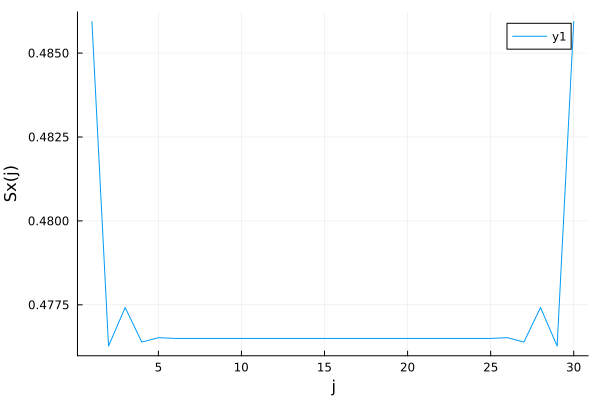

In [30]:
plot(Sx, xlabel = "j", ylabel = "Sx(j)")

### f) Calculate and plot (as a heat mat) the ground state correlations ⟨SzSz⟩ for all pairs of sites j, k of the system (3 points).

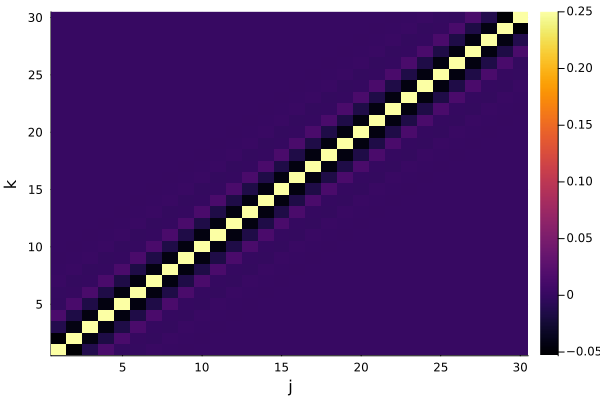

In [31]:
heatmap(SzSz, xlabel = "j", ylabel = "k")

### g) Calculate the first excited state |ψ1⟩, first excited state energy E1, and the energy gap E1 −E0 of the Hamiltonian (3 points).

In [32]:
mutable struct DmrgObserver <: AbstractObserver
    energy_tol::Float64
    last_energy::Float64
 
    DmrgObserver(energy_tol=0.0) = new(energy_tol,1000.0)
 end

In [33]:
function ITensors.checkdone!(o::DmrgObserver;kwargs...)
    sw = kwargs[:sweep]
    energy = kwargs[:energy]
  
    # Stop DMRG if current sweep sequence converged
    if (abs(energy-o.last_energy)/abs(energy) < o.energy_tol)  
      println("Stopping DMRG after sweep $sw") 
      return true
    end
      
    # Otherwise, update last_energy and keep going
    o.last_energy = energy
    return false
  end

In [34]:
function ExcitedState(H,ψi,ψ0)

    # Do many sweeps of DMRG, gradually increasing the maximum MPS bond dimension
    nsweeps = 50;
    #maxdim = [10 20 30 50 80 100 120]
    maxdim= 200
    cutoff = [1E-12]
    #noise = [1E-6]; # Could also use setnoise!
    noise = [1E-6]
    obs = DmrgObserver(1E-15) # Convergence criterium

    # Run the DMRG algorithm for ground state   
    energy1,ψ1 = dmrg(H,[ψ0],ψi; nsweeps, maxdim, cutoff, noise, observer=obs, outputlevel=1)
    
    @show energy1

    # Orthonormalize state. Leave site 1 as orthogonalization center
    orthogonalize!(ψ1,1)

    return energy1, ψ1;
    
end

ExcitedState (generic function with 1 method)

In [35]:
ψi = InitialState(sites,N);

In [36]:
E1,ψ1 = ExcitedState(H,ψi,ψ0);
Gap = E1 - E0;

@show Gap;

After sweep 1 energy=-30.73619470102431  maxlinkdim=29 maxerr=9.98E-13 time=4.185
After sweep 2 energy=-30.75134374498499  maxlinkdim=35 maxerr=9.84E-13 time=0.356
After sweep 3 energy=-30.75134883056959  maxlinkdim=20 maxerr=9.84E-13 time=0.130
After sweep 4 energy=-30.7513488350694  maxlinkdim=13 maxerr=9.79E-13 time=0.068
After sweep 5 energy=-30.75134883506979  maxlinkdim=13 maxerr=9.76E-13 time=0.054
After sweep 6 energy=-30.751348835069862  maxlinkdim=13 maxerr=9.76E-13 time=0.051
After sweep 7 energy=-30.75134883506984  maxlinkdim=13 maxerr=9.76E-13 time=0.044
Stopping DMRG after sweep 7
energy1 = -30.75134883506984
Gap = 1.0000000000249756


In [37]:
Ein = inner(ψ0,ψ1);
@show Ein;

Ein = 0.9999999999947209


In [38]:
E1 = inner(ψ1',H,ψ1);
@show E1;

E1 = -31.751348835059268


In [39]:
H2 = inner(H,ψ1,H,ψ1)
var = H2-E1^2
@show var

var = 6.058371582184918e-10


6.058371582184918e-10